<a href="https://colab.research.google.com/github/Harsh-58/DataScienceA2/blob/main/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
# data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
#identifies all the different amino acids in our data set
aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
#for pymc to properly read the categories
aa_coords = {"aa": aa_encode.categories}

In [ ]:
cs_data

,ID,aa,theo,exp,diff_TminusE,cat
0,1BM8,ILE,61.18,58.27,2.91,Non-Polar
1,1BM8,TYR,56.95,56.18,0.77,Polar
2,1BM8,SER,56.35,56.84,-0.49,Polar
3,1BM8,ALA,51.96,51.01,0.95,Special
4,1BM8,ARG,56.54,54.64,1.90,Charged
...,...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,-1.72,Charged
1772,1KS9,ARG,58.91,59.02,-0.11,Charged
1773,1KS9,LYS,59.49,58.92,0.57,Charged
1774,1KS9,GLU,59.48,58.36,1.12,Charged


In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

Output()

Output()

In [ ]:
with pm.Model(coords=aa_coords) as cs_hstu_model:
    # hyperpriors
    # hyperprior shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', nu=5, mu = 0, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd', nu=5, sigma = 10)
    ν_nu = pm.HalfStudentT('ν_nu', nu=5, sigma=10)

    # priors. different prior for each amino acid
    μ = pm.StudentT('μ',
                  nu = ν_nu,
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', nu = 5, sigma = 10,
                      dims = "aa")

    ν = pm.HalfStudentT('ν', nu = 5, sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.StudentT('y',
                  nu = ν[aa_idx],
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical, stu for student T version
    idata_cs_hstu = pm.sample()

Output()

Output()

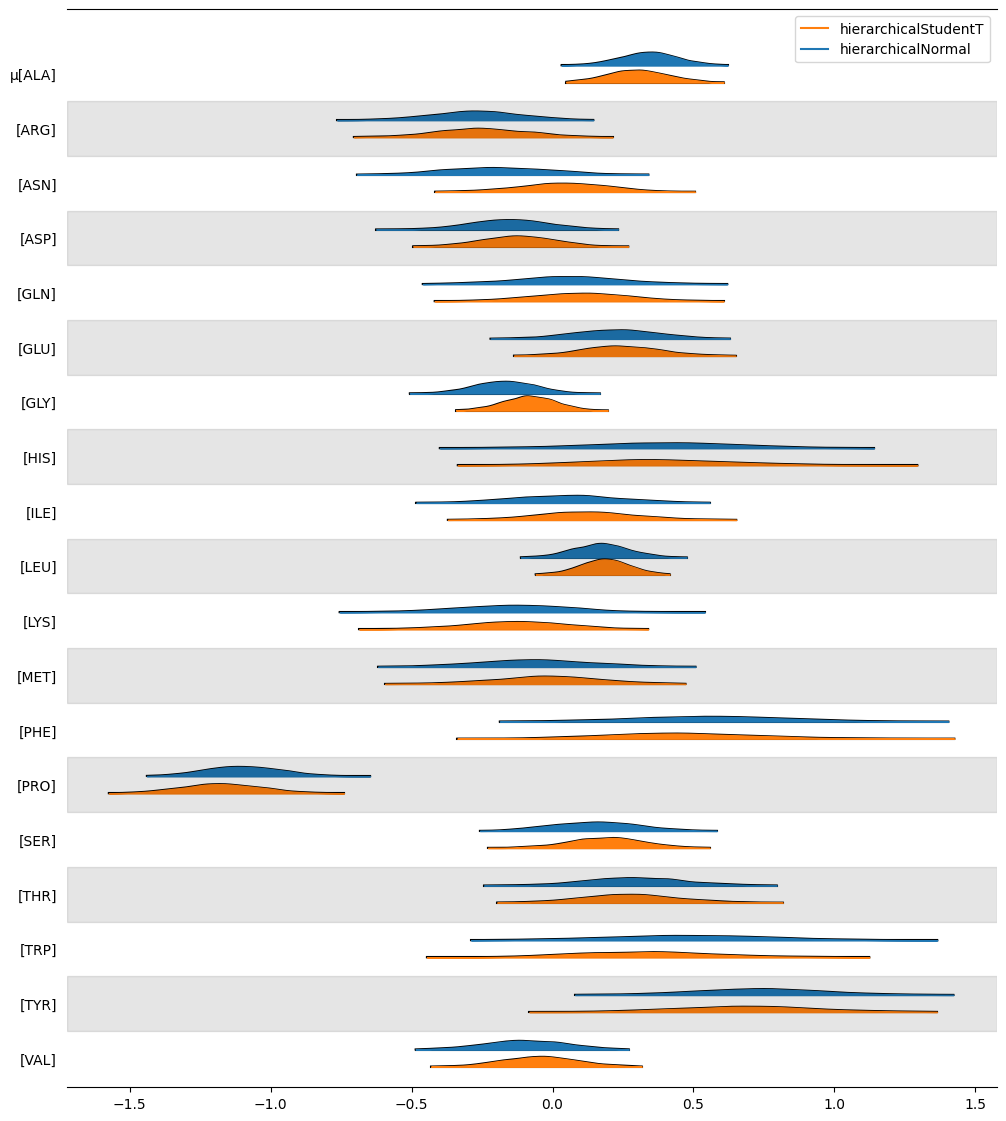

In [ ]:
axes = az.plot_forest([idata_cs_h, idata_cs_hstu], kind="ridgeplot",
                      model_names=['hierarchicalNormal', 'hierarchicalStudentT'],
                      var_names='μ', combined=True, figsize=(12, 14),hdi_prob=0.997)

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

<Axes: xlabel='y'>

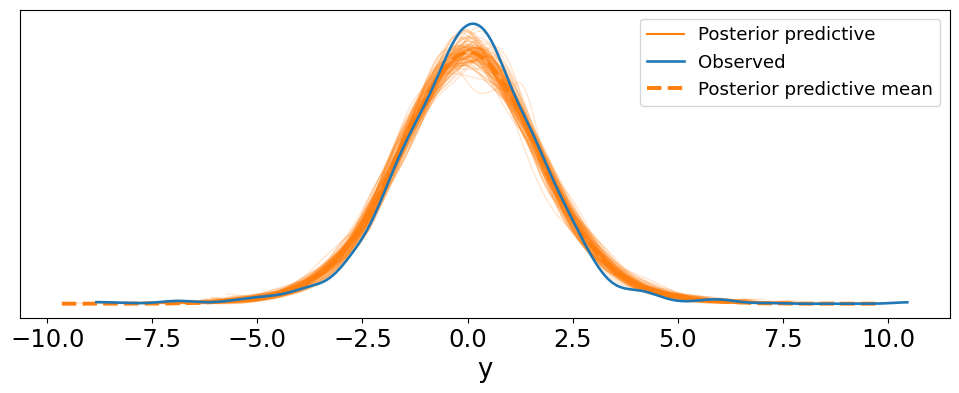

In [ ]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Output()

(-10.0, 10.0)

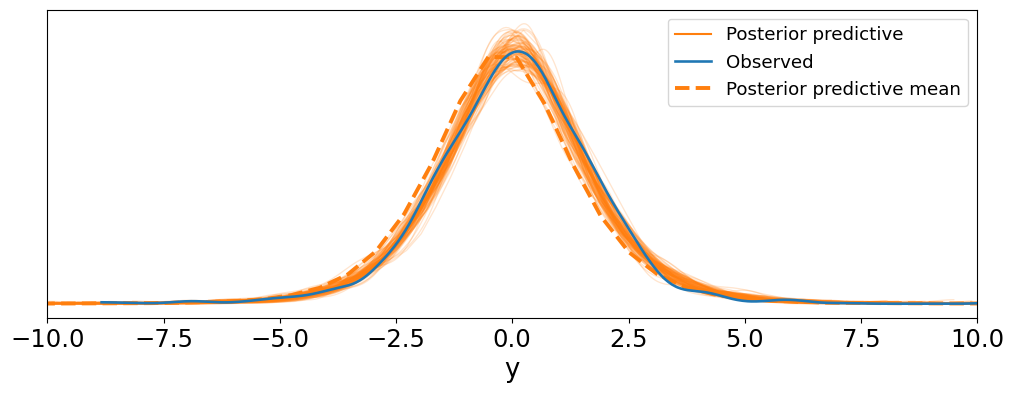

In [ ]:
pm.sample_posterior_predictive(idata_cs_hstu, model=cs_hstu_model, extend_inferencedata=True)
ax=az.plot_ppc(idata_cs_hstu, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(-10, 10)

The hierarchical model using StudentT and HalfStudentT priors looks like it fit the data more effectively. This is shown around the peak and in the small section to the right, near the value of 3. At these points, it's clear that the StudentT model makes more accurate predictions and fits the overall data better.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:
#load the data
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})
# array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [ ]:
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


<Axes: ylabel='goals'>

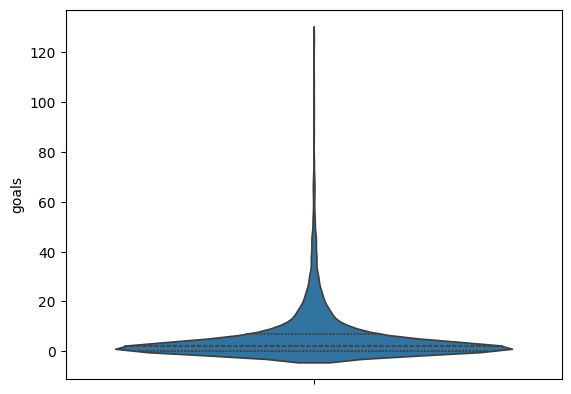

In [ ]:
sns.violinplot(sccr_data.goals,inner='quart')


In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:

    # Parameters for positions
    μ_p = pm.Beta('μ_p', alpha = 2, beta = 20, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.98)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.0 1.002 1.004 ... 1.001 0.9996 1.001
    μ_p      (pos) float64 32B 1.003 1.0 1.086 1.0
    ν_p      (pos) float64 32B 1.036 1.0 1.182 1.005

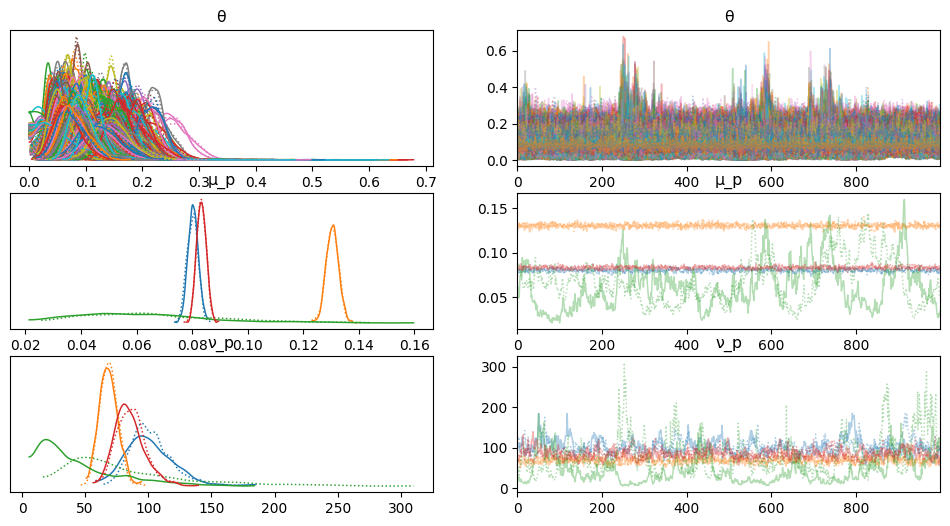

In [ ]:
az.plot_trace(idata_sccr)
az.rhat(idata_sccr)

Compared to the hierarchical model shown in the answer key, the Rhat values in the non-hierarchical model are much closer to the ideal range of 1 to 1.001. Most values fall within this range, with any outliers only slightly exceeding it. Even for the goalkeeper position, the Rhat values are still under 1.1—though slightly above the ideal 1.09, it’s a considerable improvement from the 1.242 recorded in the hierarchical model.

The trace plots look fairly similar overall. In the μ_p graph, the peaks for the red line are a bit higher in the non-hierarchical model, but the solid and dotted lines remain closely aligned throughout. In the ν_p graph, the non-hierarchical model’s traces look slightly cleaner, except for the green line, which shows a bit more variation.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

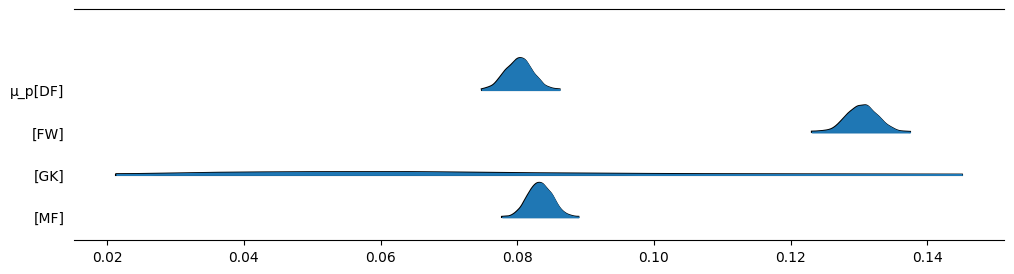

In [ ]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

The posteriors in this model are narrower and smoother compared to the hierarchical model we discussed in class. This suggests that they reflect a bit more certainty, as the model is generating more concentrated and less variable estimates than before.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [ ]:
sccr_data_noG = sccr_data[sccr_data.position != 'GK'].copy()
sccr_data_noG['position'] = pd.Categorical(sccr_data_noG['position'])
sccr_data_noG['position'] = sccr_data_noG['position'].cat.remove_unused_categories()

In [ ]:
pos_idx_noG = sccr_data_noG.position.cat.codes.values

pos_codes_noG = sccr_data_noG.position.cat.categories

sccr_coords_noG = {"pos": pos_codes_noG}

print(pos_codes_noG)
print(sccr_coords_noG)

Index(['DF', 'FW', 'MF'], dtype='object')
{'pos': Index(['DF', 'FW', 'MF'], dtype='object')}


In [ ]:
with pm.Model(coords = sccr_coords_noG) as sccr_model_noG:
    # Hyper parameters
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx_noG], nu = ν_p[pos_idx_noG])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data_noG.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data_noG.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_noG = pm.sample(target_accept = 0.95)



Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([<Axes: >], dtype=object)

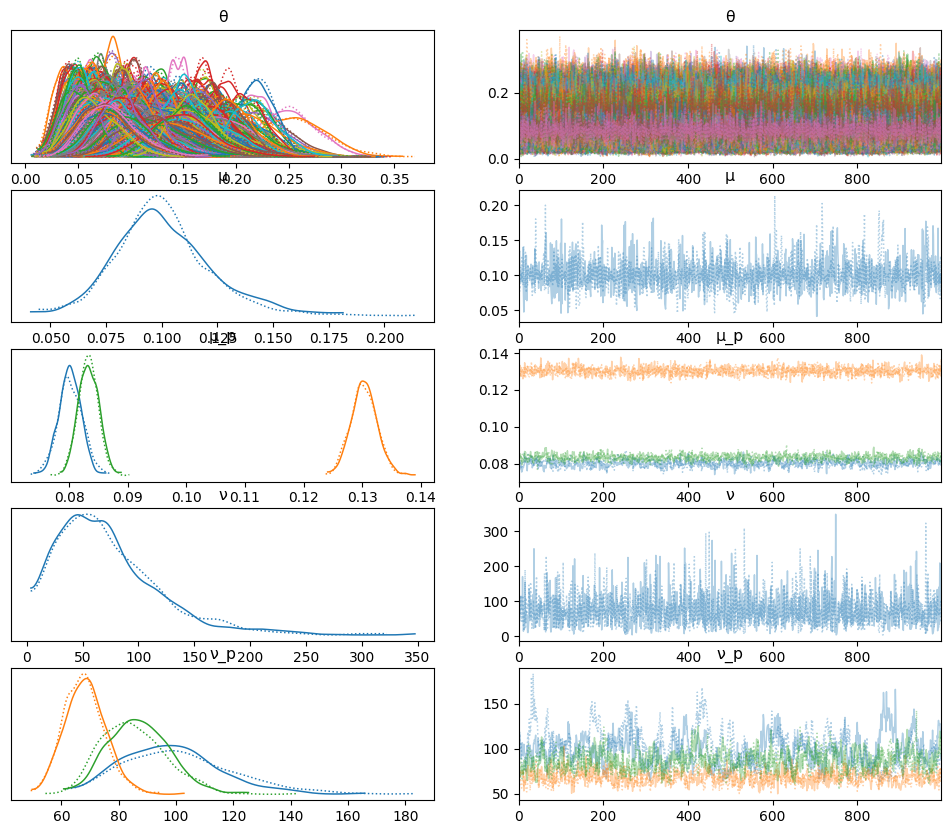

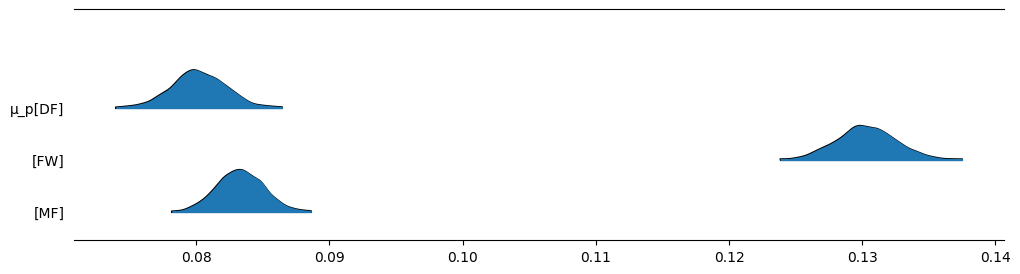

In [ ]:
az.plot_trace(idata_sccr_noG)
az.rhat(idata_sccr_noG)
az.plot_forest(idata_sccr_noG, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

The model without goalkeepers looks much cleaner, likely due to their exclusion, which seems to make the other positions more organized. Processing this version of the model was also much faster, taking a couple minutes less than the other one. However, removing goalkeepers from the dataset comes with some downsides. We lose the unique insight that goalkeepers can score and their inherent unpredictability, which reduces the diversity of playing positions in our analysis. Even though it is quite uncommon for a keeper to score it would be wrong to get rid of all outliers. This limitation affects our ability to fully understand the game's complex dynamics. However, this adjustment brings increased efficiency, simplicity, and clarity, making it easier to interpret and visualize the results.